In [1]:
import pandas as pd
import numpy as np
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import warnings
warnings.filterwarnings('ignore')

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Airport Model Validation - CBX

In [3]:
wd = r'C:\Users\hannah.carson\OneDrive - Resource Systems Group, Inc\SANDAG\airport_model\abm2'
ctramp = pd.read_csv(os.path.join(wd,'output','airport_out.CBX.csv'))
asim = pd.read_csv(os.path.join(wd,'output','final_cbxtrips.csv'))
tours = pd.read_csv(os.path.join(wd,'output','final_cbxtours.csv'))
asim = asim.merge(tours[['tour_id','direction','tour_type','income','nights','party_size']], how = 'left', on = 'tour_id')
ctramp = ctramp.rename(columns = {'id':'trip_id'})
lu = pd.read_csv(os.path.join(wd,'input','mgra13_based_input2016.csv'))
skims = pd.read_csv(os.path.join(wd,'input','skims.csv'))

## Check Trip Totals

In [6]:
asim = asim[asim.trip_num ==1]

In [7]:
print("CTRamp Trips: {:,.0f}\nASIM Trips: {:,.0f}".format(len(ctramp[(ctramp['purpose'] < 4) ]),len(asim[asim['tour_type'] != 'external'])))

CTRamp Trips: 907
ASIM Trips: 972


In [9]:
asim['income'] = asim['income'].astype(int)


In [11]:
ctramp_dist = ctramp[ctramp.purpose < 5]
asim_dist = asim[asim.tour_type != 'emp']

ctramp_dist['share'] = 1/len(ctramp_dist)
asim_dist['share'] = 1/len(asim_dist)

ctramp_dist['source'] = 'ctramp'
asim_dist['source'] = 'asim'
ctramp_dist['party_size'] = ctramp_dist['size']

distributions = ctramp_dist[['party_size','income','nights','share','source']].append(asim_dist[['party_size','income','nights','share','source']])



In [12]:
print(len(ctramp_dist),len(asim_dist))

2270 2270


Text(0.5, 1.0, 'Airport Party Size')

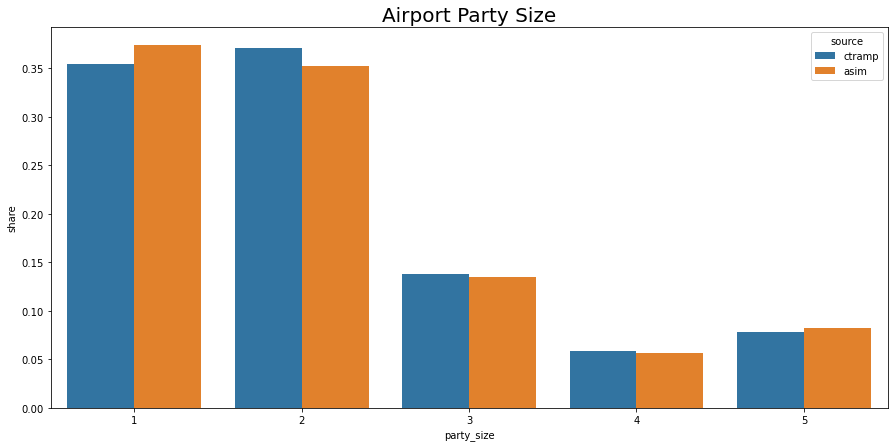

In [13]:
fig,ax0 = plt.subplots(figsize=(15,7))
sns.barplot(data=distributions.groupby(['party_size','source'],as_index = False)[['share']].sum().sort_values('source',ascending = False), x='party_size', y='share', hue='source',ax = ax0)
ax0.set_title("Airport Party Size", fontsize = 20)

Text(0.5, 1.0, 'Airport Party Income')

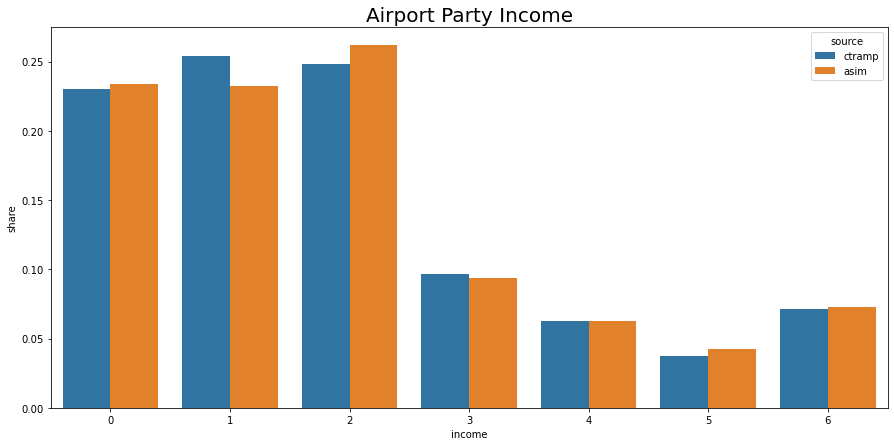

In [14]:
fig,ax0 = plt.subplots(figsize=(15,7))
sns.barplot(data=distributions.groupby(['income','source'],as_index = False)[['share']].sum().sort_values('source',ascending = False), x='income', y='share', hue='source',ax = ax0)
ax0.set_title("Airport Party Income", fontsize = 20)

Text(0.5, 1.0, 'Airport Party Nights')

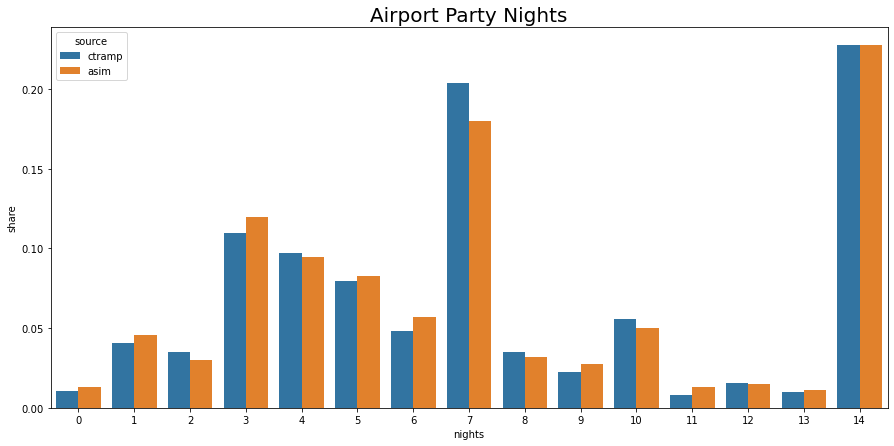

In [15]:
fig,ax0 = plt.subplots(figsize=(15,7))
sns.barplot(data=distributions.groupby(['nights','source'],as_index = False)[['share']].sum().sort_values('source',ascending = False), x='nights', y='share', hue='source',ax = ax0)
ax0.set_title("Airport Party Nights", fontsize = 20)

In [16]:
#code choice end of trip
asim['destination_choice'] = asim['destination']
asim.loc[asim.destination_choice == 7061, 'destination_choice'] = asim[asim.destination_choice == 7061]['origin']
asim = asim.merge(lu[['mgra','taz','pseudomsa']], how = 'left', left_on = 'destination_choice', right_on = 'mgra')
asim = asim.merge(skims[['j','dist']], how = 'left', left_on = 'taz', right_on = 'j')
ctramp['destination_choice'] = ctramp['destinationMGRA']
ctramp.loc[ctramp.direction == 0, 'destination_choice'] = ctramp[ctramp.direction == 0]['originMGRA']
ctramp.loc[ctramp.direction == 1, 'destination_choice'] = ctramp[ctramp.direction == 1]['destinationMGRA']
ctramp = ctramp.merge(lu[['mgra','taz','pseudomsa']], how = 'left', left_on = 'destination_choice', right_on = 'mgra')
ctramp = ctramp.merge(skims[['j','dist']], how = 'left', left_on = 'taz', right_on = 'j')


In [17]:
print(len(asim),len(ctramp))

2270 2270


## Purpose Shares

In [18]:
asim['tour_type'] = asim['tour_type'].map(lambda s: ''.join([i for i in s if not i.isdigit()]))
purp_map = {0:'res_bus',1:'res_per',2:'vis_bus',3:'vis_per',4:'external',5:'emp'}
ctramp['tour_type'] = ctramp['purpose'].map(purp_map)


In [19]:
asim_ii = asim[~asim.tour_type.isin(['emp','external'])]
ctramp_ii = ctramp[~ctramp.tour_type.isin(['emp','external'])]

In [20]:
asim['tour_type'].unique()

array(['res_per', 'vis_per', 'res_bus', 'vis_bus', 'external'],
      dtype=object)

In [21]:
asim.primary_purpose.unique()

array(['per2', 'per3', 'bus1', 'per4', 'per7', 'per1', 'per6', 'per5',
       'bus5', 'bus2', 'bus3', 'bus7', 'bus4', 'ext1', 'ext2', 'ext3',
       'ext4', 'ext6', 'ext5', 'ext7'], dtype=object)

In [22]:
purp_shares = pd.DataFrame((
    (ctramp.groupby('tour_type')['trip_id'].count()/ctramp_ii['trip_id'].count()),
    (asim['tour_type'].value_counts() / len(asim))))
purp_shares.index = ['ctramp', 'asim']
purp_shares.index.name = 'source'
purp_shares.reset_index(inplace=True)
purp_shares = purp_shares.melt(id_vars='source', value_name='share', var_name='tour_type')

asim_purpose_shares = pd.DataFrame(asim['tour_type'].value_counts(sort=False) / asim.shape[0]).reset_index()
asim_purpose_shares.columns = ['purpose', 'share']
asim_purpose_shares['source'] = 'asim'
ctramp_purpose_shares = pd.DataFrame(ctramp['tour_type'].value_counts(sort=False) / ctramp.shape[0]).reset_index()
ctramp_purpose_shares.columns = ['purpose', 'share']
ctramp_purpose_shares['source'] = 'ctramp'
purpose_shares = pd.concat((asim_purpose_shares, ctramp_purpose_shares))



In [23]:
purpose_shares

,purpose,share,source
0,res_per,0.236564,asim
1,vis_per,0.111454,asim
2,res_bus,0.063877,asim
3,vis_bus,0.016300,asim
4,external,0.571806,asim
0,external,0.600441,ctramp
1,vis_per,0.105727,ctramp
2,res_per,0.209692,ctramp
3,res_bus,0.062555,ctramp
4,vis_bus,0.021586,ctramp


Text(0.5, 1.0, 'Purpose Shares')

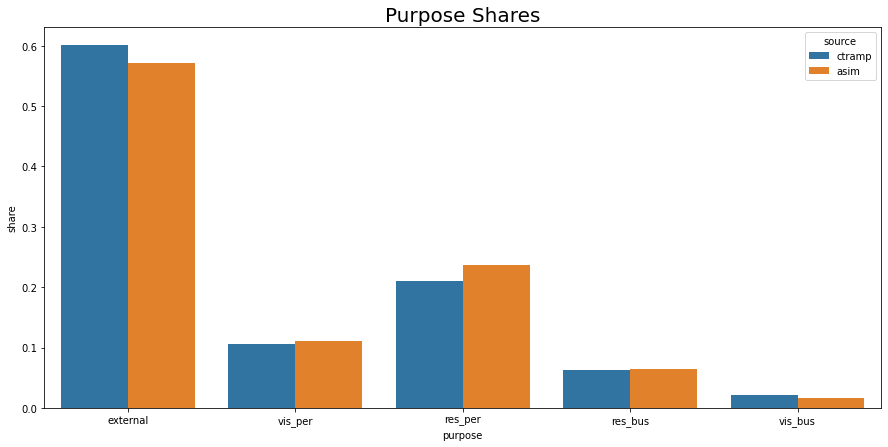

In [24]:
fig,ax0 = plt.subplots(figsize=(15,7))
sns.barplot(data=purpose_shares.sort_values('source',ascending = False), x='purpose', y='share', hue='source',ax = ax0)
ax0.set_title("Purpose Shares", fontsize = 20)

## Destination Choice

In [25]:
ctramp_ii['source'] = 'ctramp'
asim_ii['source'] = 'asim'
ctramp_ii_pct = ctramp_ii.groupby('tour_type',as_index = False)['trip_id'].count().rename(columns = {'trip_id':'purp_total'})
asim_ii_pct = asim_ii.groupby('tour_type',as_index = False)['trip_id'].count().rename(columns = {'trip_id':'purp_total'})

ctramp_ii = ctramp_ii.merge(ctramp_ii_pct, how = 'left', on = 'tour_type')
asim_ii = asim_ii.merge(asim_ii_pct, how = 'left', on = 'tour_type')
ctramp_ii['pct_trips'] = 1/ctramp_ii['purp_total']
asim_ii['pct_trips'] = 1/asim_ii['purp_total']


In [26]:
print(len(ctramp_ii),len(asim_ii))

907 972


Text(0.5, 1.0, 'Destination Choice PMSA')

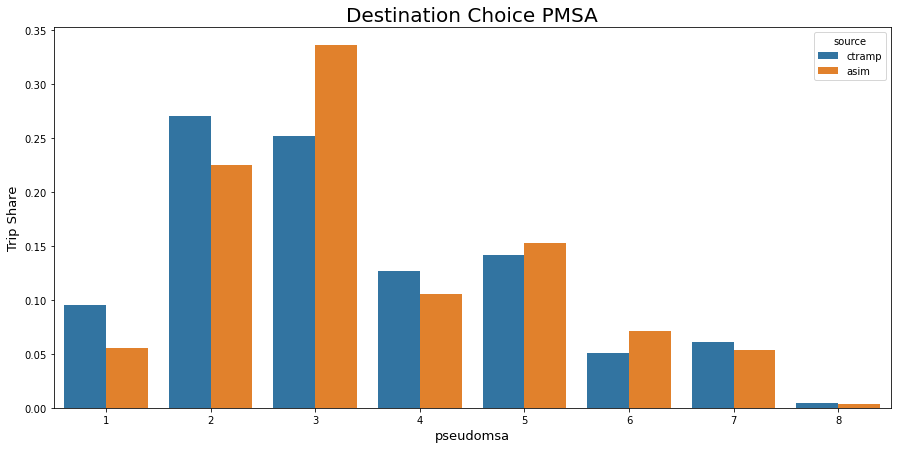

In [27]:
fig,ax1 = plt.subplots(figsize=(15,7))
dest_share_ct = ctramp_ii.groupby(['pseudomsa'])[['trip_id']].count()/len(ctramp_ii)
dest_share_ct['source'] = 'ctramp'

dest_share_as = asim_ii.groupby(['pseudomsa'])[['trip_id']].count()/len(asim_ii)
dest_share_as['source'] = 'asim'

fig = sns.barplot(data=dest_share_ct.append(dest_share_as).reset_index(), x='pseudomsa', y='trip_id', hue='source', ci = None)
ax1.set_ylabel('Trip Share', fontsize=13)
ax1.set_xticklabels(labels=ax1.get_xticklabels(),fontsize=10)
ax1.set_xlabel(ax1.get_xlabel(), fontsize=13)
ax1.set_title("Destination Choice PMSA", fontsize = 20)

In [28]:
dest_choice = pd.concat([dest_share_ct[['trip_id']], dest_share_as[['trip_id']]], axis =1)
dest_choice.columns = ['ctramp','asim']
dest_choice['diff'] = dest_choice['asim'] - dest_choice['ctramp']

dest_choice['ctramp'] = dest_choice['ctramp'].map(lambda n: "{:.2f}%".format(n*100))
dest_choice['asim'] = dest_choice['asim'].map(lambda n: "{:.2f}%".format(n*100))
dest_choice['diff'] = dest_choice['diff'].map(lambda n: "{:.2f}%".format(n*100))
dest_choice

,ctramp,asim,diff
pseudomsa,,,
1,9.48%,5.56%,-3.93%
2,27.01%,22.43%,-4.58%
3,25.14%,33.54%,8.40%
4,12.68%,10.49%,-2.19%
5,14.11%,15.23%,1.11%
6,5.07%,7.10%,2.03%
7,6.06%,5.35%,-0.71%
8,0.44%,0.31%,-0.13%


Text(0.5, 1.0, 'Destination Choice PMSA')

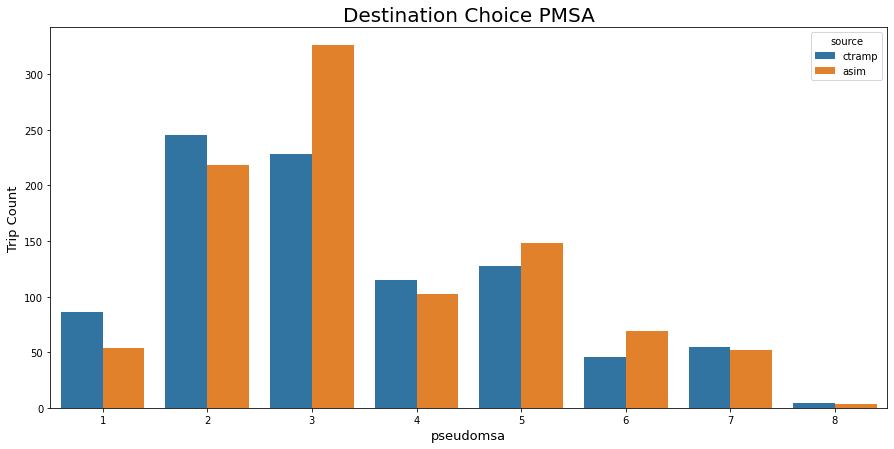

In [29]:
fig,ax1 = plt.subplots(figsize=(15,7))
dest_share_ct = ctramp_ii.groupby(['pseudomsa'])[['trip_id']].count()
dest_share_ct['source'] = 'ctramp'

dest_share_as = asim_ii.groupby(['pseudomsa'])[['trip_id']].count()
dest_share_as['source'] = 'asim'

fig = sns.barplot(data=dest_share_ct.append(dest_share_as).reset_index(), x='pseudomsa', y='trip_id', hue='source', ci = None)
ax1.set_ylabel('Trip Count', fontsize=13)
ax1.set_xticklabels(labels=ax1.get_xticklabels(),fontsize=10)
ax1.set_xlabel(ax1.get_xlabel(), fontsize=13)
ax1.set_title("Destination Choice PMSA", fontsize = 20)

In [30]:
dest_choice = pd.concat([dest_share_ct[['trip_id']], dest_share_as[['trip_id']]], axis =1)
dest_choice.columns = ['ctramp','asim']
dest_choice['diff'] = dest_choice['asim'] - dest_choice['ctramp']
dest_choice.loc['Total'] = dest_choice.sum()

dest_choice['ctramp'] = dest_choice['ctramp'].map(lambda n: "{:.0f}".format(n))
dest_choice['asim'] = dest_choice['asim'].map(lambda n: "{:.0f}".format(n))
dest_choice['diff'] = dest_choice['diff'].map(lambda n: "{:.0f}".format(n))
dest_choice

,ctramp,asim,diff
pseudomsa,,,
1,86,54,-32
2,245,218,-27
3,228,326,98
4,115,102,-13
5,128,148,20
6,46,69,23
7,55,52,-3
8,4,3,-1
Total,907,972,65


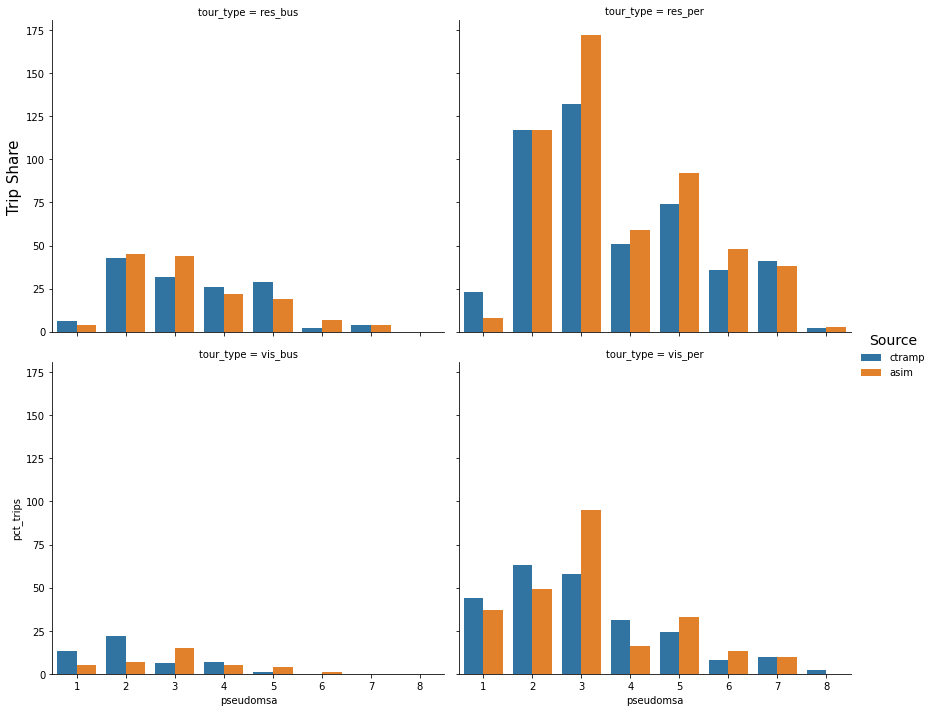

In [31]:
dest_share_ct = ctramp_ii.groupby(['tour_type','pseudomsa'],as_index = False)['pct_trips'].count()
dest_share_ct['source'] = 'ctramp'

dest_share_as = asim_ii.groupby(['tour_type','pseudomsa'],as_index = False)['pct_trips'].count()
dest_share_as['source'] = 'asim'
g = sns.catplot(
    data=dest_share_ct.append(dest_share_as).reset_index(), x='pseudomsa', y='pct_trips', hue='source', kind='bar', col='tour_type',
    aspect=1.2, legend_out=True, alpha=1, col_wrap = 2)
g._legend.set_title('Source', prop={'size':14})
g.axes[0].set_ylabel('Trip Share', fontsize=15)
g.axes[0].set_xlabel('destination pseudoMSA', fontsize=12)
_ = g.axes[0].set_xlabel('destination pseudoMSA', fontsize=12)

In [32]:
# dest_share = dest_share_ct.append(dest_share_as).pivot(index = ['tour_type','pseudomsa'], columns = 'source', values = 'pct_trips')
# dest_share['ctramp'] = dest_share['ctramp'].map(lambda n: "{:.2f}%".format(n*100))
# dest_share['asim'] = dest_share['asim'].map(lambda n: "{:.2f}%".format(n*100))
# dest_share[['ctramp','asim']]

## Tour Length Distribution

In [33]:
print(len(asim),len(ctramp))

2270 2270


Text(0.5, 0, 'trip distance')

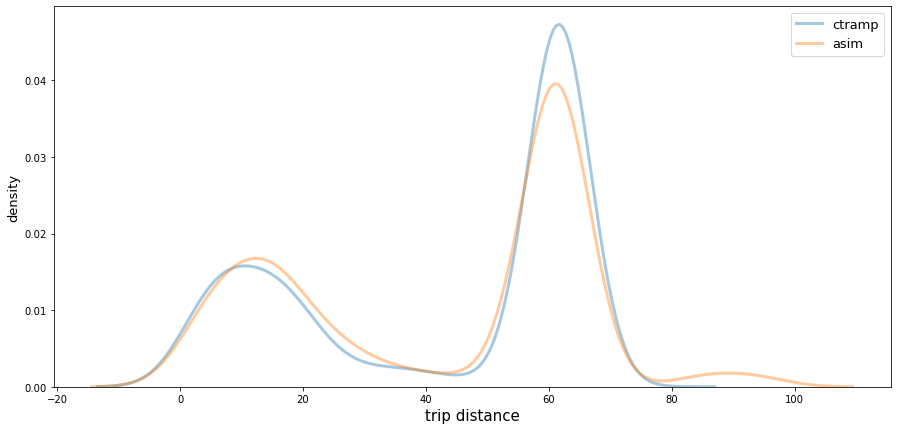

In [34]:
fig, ax = plt.subplots(figsize=(15,7))
sns.kdeplot(data=ctramp, x='dist', ax=ax, label='ctramp', alpha=0.4, lw=3, )
sns.kdeplot(data=asim, x='dist', ax=ax, label='asim', alpha=0.4, lw=3)
ax.legend(fontsize=13)
ax.set_ylabel('density', fontsize=13)
ax.set_xlabel('trip distance', fontsize=15)


In [35]:
asim_bin_dict = {1:1,2:1,3:1,4:1,5:2,6:3,7:4,8:5,9:6,10:7,11:8,12:9,13:10,14:11,15:12,16:13,17:14,18:15,19:16,20:17,21:18,
                 22:19,23:20,24:21,25:22,26:23,27:24,28:25,29:26,30:27,31:28,32:29,33:30,34:31,35:32,36:33,37:34,38:35,
                 39:36,40:37,41:38,42:39,43:40,44:40,45:40,46:40,47:40,48:40}
ct_bin_dict = {1:'3-5',2:'5:00',3:'5:30',4:'6:00',3:'6:30',6:'7:00',7:'7:30',8:'8:00',9:'8:30',10:'9:00',11:'9:30',12:'10:00',
               13:'10:30',14:'11:00',15:'11:30',16:'12:00',17:'12:30',18:'13:00',19:'13:30',20:'14:00',21:'14:30',22:'15:00',
               23:'15:30',24:'16:00',25:'16:30',26:'17:00',27:'17:30',28:'18:00',29:'18:30',30:'19:00',31:'19:30',32:'20:00',
               33:'20:30',34:'21:00',35:'21:30',36:'22:00',37:'22:30',38:'23:00',39:'23:30',40:'24-3',}
ctramp['depart_bin'] = ctramp['departTime']#.map(ct_bin_dict)
asim['depart_bin'] = asim['depart'].map(asim_bin_dict)

## Trip Scheduling

Text(0.5, 0, 'trip depart bin')

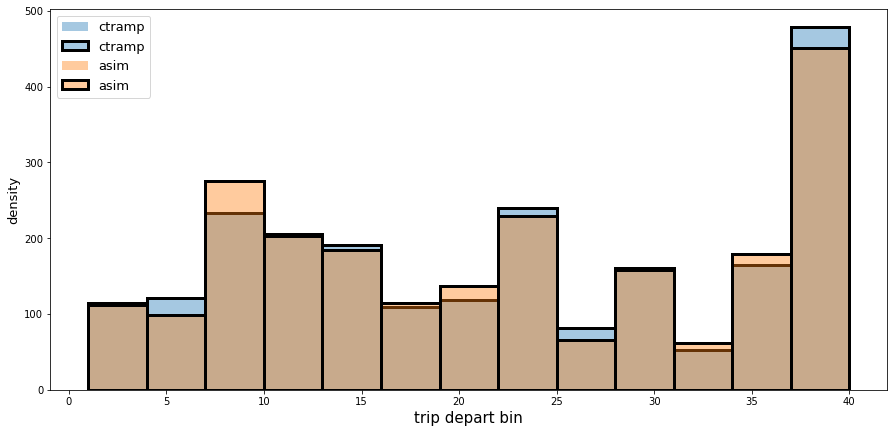

In [36]:

fig, ax = plt.subplots(figsize=(15,7))
sns.histplot(ctramp.sort_values('departTime'), x='depart_bin', ax=ax, label='ctramp', alpha=0.4, lw=3, )
sns.histplot(asim.sort_values('depart'), x='depart_bin', ax=ax, label='asim', alpha=0.4, lw=3)
ax.legend(fontsize=13)
ax.set_ylabel('density', fontsize=13)
ax.set_xlabel('trip depart bin', fontsize=15)


In [37]:
# ctramp['dir'] = ctramp['direction'].map({1:'inbound',0:'outbound'})
# asim['dir'] = asim['direction']
# fig, ax = plt.subplots(figsize=(15,7))
# sns.histplot(ctramp[ctramp['dir'] == 'inbound'], x='depart_bin', ax=ax, label='ctramp', alpha=0.4, lw=3, )
# sns.histplot(asim[asim['dir'] == 'inbound'], x='depart_bin', ax=ax, label='asim', alpha=0.4, lw=3)
# ax.legend(fontsize=13)
# ax.set_ylabel('density', fontsize=13)
# ax.set_xlabel('trip depart bin', fontsize=15)


In [38]:
ctramp['dir'] = ctramp['direction'].map({1:'inbound',0:'outbound'})
asim['dir'] = asim['direction']
# fig, ax = plt.subplots(figsize=(15,7))
# sns.histplot(ctramp[ctramp['dir'] == 'outbound'], x='depart_bin', ax=ax, label='ctramp', alpha=0.4, lw=3, )
# sns.histplot(asim[asim['dir'] == 'outbound'], x='depart_bin', ax=ax, label='asim', alpha=0.4, lw=3)
# ax.legend(fontsize=13)
# ax.set_ylabel('density', fontsize=13)
# ax.set_xlabel('trip depart bin', fontsize=15)


In [39]:
asim['source'] = 'asim'
ctramp['source'] = 'ctramp'

In [40]:
asim.tour_type.unique()
asim['purpose'] = asim['tour_type'].map({'res_bus':0, 'res_per':1, 'vis_bus':2, 'vis_per':3, 'emp': 5,'external':4})

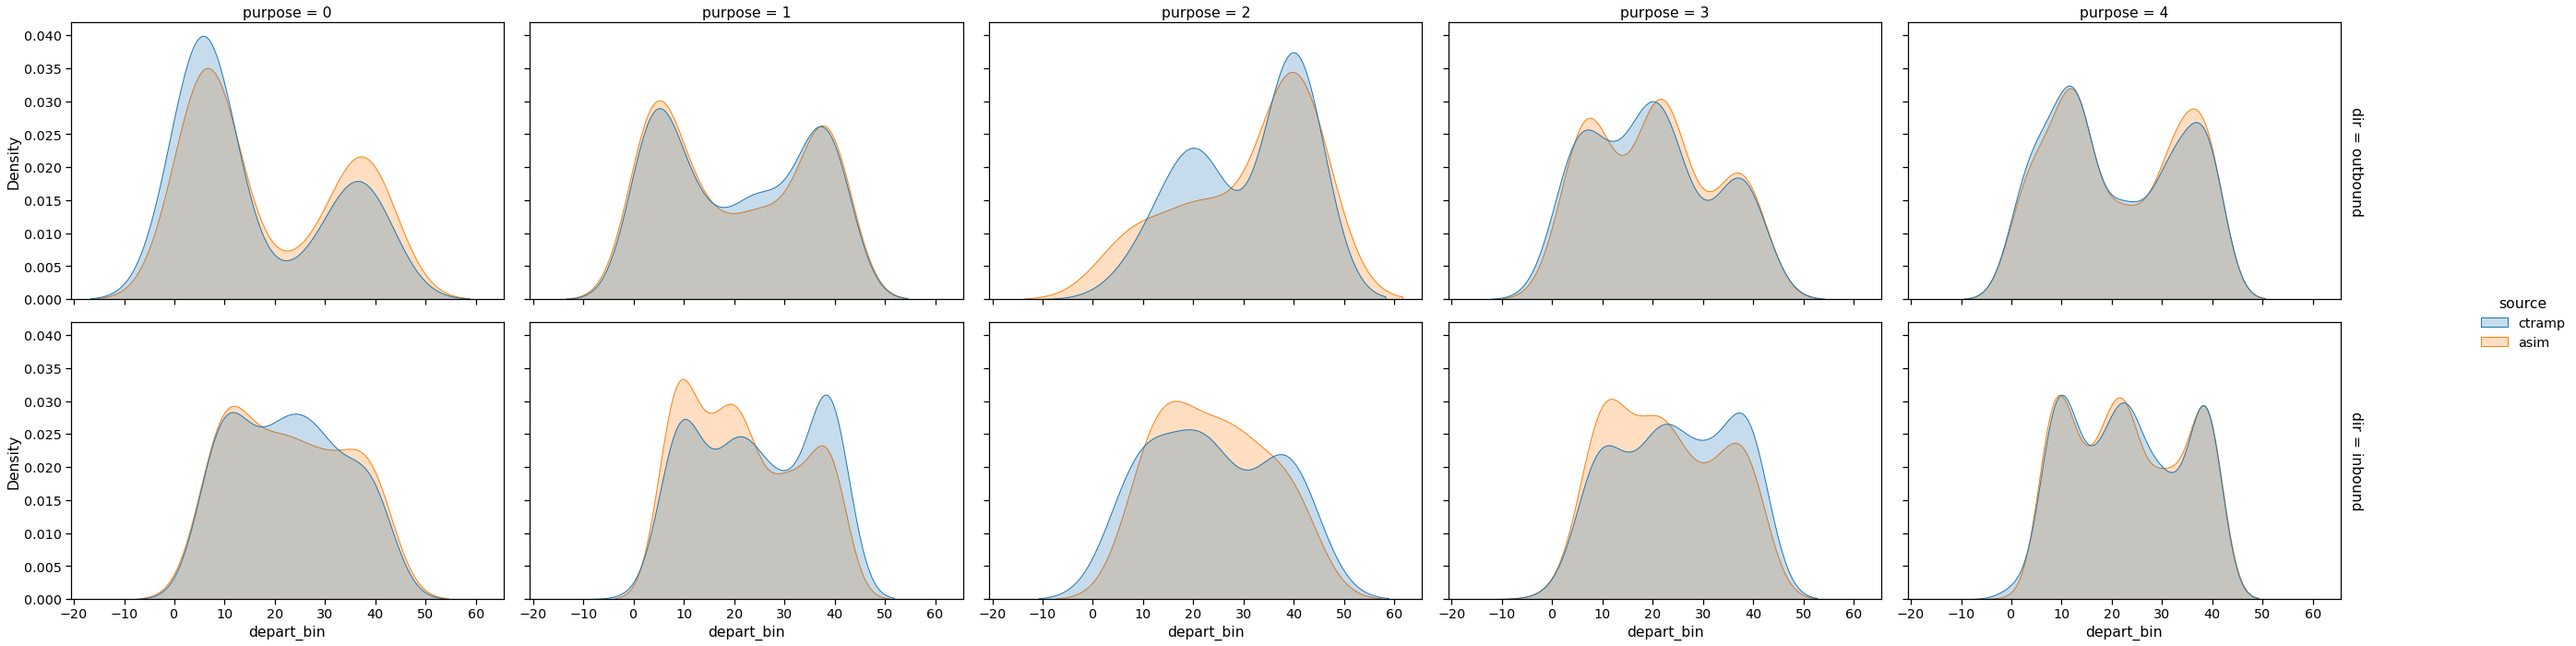

In [41]:
ctramp['dir'] = ctramp['direction'].map({0:'outbound',1:'inbound'})

trip_sched = asim[['source','dir','purpose','depart_bin']].append(ctramp[['source','dir','purpose','depart_bin']])
with sns.plotting_context("notebook",font_scale=1.3):
    sns.displot(
        data=trip_sched.sort_values('source', ascending = False), x='depart_bin', col='purpose',row='dir',hue='source',
        kind='kde', fill=True, aspect=1.5, common_norm=False,
        facet_kws={'sharex': True, 'sharey': True, 'despine':False, 'margin_titles':True})

## Trip Distance distribution

Text(0.5, 0, 'trip distance')

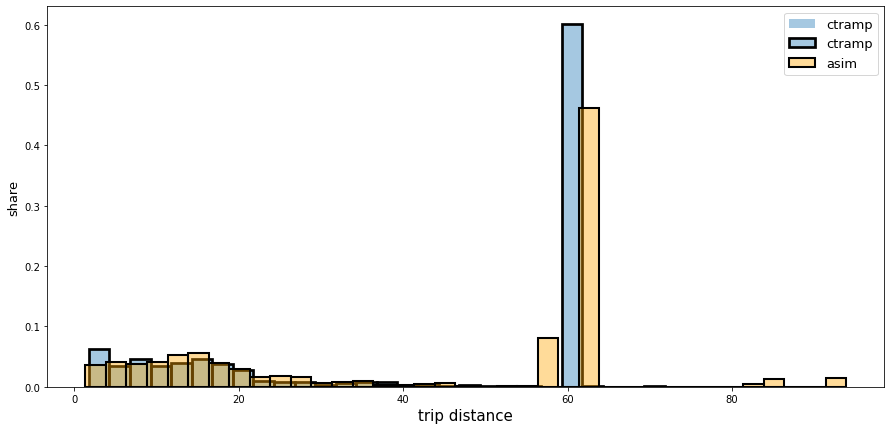

In [42]:
fig, ax = plt.subplots(figsize=(15,7))
asim['weight'] = 1/len(asim)
ctramp['weight'] = 1/len(ctramp)
sns.histplot(data=ctramp, x='dist',weights = 'weight',ax=ax,binwidth = 2.5, label='ctramp', alpha=0.4, lw=3)
sns.histplot(data=asim,  x='dist', weights = 'weight',binwidth =2.5,ax=ax, label='asim', color = 'orange',alpha=0.4, lw=3)
ax.legend(fontsize=13)
ax.set_ylabel('share', fontsize=13)
ax.set_xlabel('trip distance', fontsize=15)
# ax.set_xticklabels(['3am','5am','7:30am','10am','12:30pm','3pm','5:30pm']);

In [43]:
# dest_share_ct = ctramp_ii.groupby(['direction','pseudomsa'],as_index = False)['pct_trips'].sum()
# dest_share_ct['source'] = 'ctramp'
# dest_share_ct['direction'] = dest_share_ct['direction'].map({0:'outbound',1:'inbound'})
# dest_share_as = asim_ii.groupby(['direction','pseudomsa'],as_index = False)['pct_trips'].sum()
# dest_share_as['source'] = 'asim'
# g = sns.catplot(
#     data=dest_share_ct.append(dest_share_as).reset_index(), x='pseudomsa', y='pct_trips', hue='source', kind='bar', col='direction',
#     aspect=1.2, legend_out=True, alpha=1, col_wrap = 2)
# g._legend.set_title('Source', prop={'size':14})
# g.axes[0].set_ylabel('Trip Share', fontsize=15)
# g.axes[0].set_xlabel('destination pseudoMSA', fontsize=12)
# _ = g.axes[0].set_xlabel('destination pseudoMSA', fontsize=12)

In [44]:
# dest_share = dest_share_ct.append(dest_share_as).pivot(index = ['direction','pseudomsa'], columns = 'source', values = 'pct_trips')
# dest_share['ctramp'] = dest_share['ctramp'].map(lambda n: "{:.2f}%".format(n*100))
# dest_share['asim'] = dest_share['asim'].map(lambda n: "{:.2f}%".format(n*100))
# dest_share[['ctramp','asim']]

In [45]:
#inbound = arriving passengers, outbound = departing passengers
#  0 = departing passenger, 1 = arriving

In [46]:
ctramp.columns

Index(['trip_id', 'direction', 'purpose', 'size', 'income', 'nights',
       'departTime', 'originMGRA', 'destinationMGRA', 'originTAZ',
       'destinationTAZ', 'tripMode', 'av_avail', 'arrivalMode', 'boardingTAP',
       'alightingTAP', 'set', 'valueOfTime', 'destination_choice', 'mgra',
       'taz', 'pseudomsa', 'j', 'dist', 'tour_type', 'depart_bin', 'dir',
       'source', 'weight'],
      dtype='object')

In [47]:
ctramp.tripMode.unique()

array([ 2,  3,  1, 11, 12, 10], dtype=int64)

## Trip Mode

In [48]:
ctramp = pd.read_csv(os.path.join(wd,'output','airport_out.CBX.csv'))
asim = pd.read_csv(os.path.join(wd,'output','final_cbxtrips.csv'))
tours = pd.read_csv(os.path.join(wd,'output','final_cbxtours.csv'))
asim = asim.merge(tours[['tour_id','direction','tour_type','income','nights','party_size']], how = 'left', on = 'tour_id')
ctramp = ctramp.rename(columns = {'id':'trip_id'})


In [49]:
asim = asim[asim.trip_num ==1]

In [50]:
# ctramp = ctramp[((ctramp['purpose'] < 4) )]
# ctramp = ctramp[((ctramp['arrivalMode'] < 4) )]
# asim = asim[~asim['tour_type'].isin(['external','emp']) ]

In [51]:
asim['tour_type'] = asim['tour_type'].map(lambda s: ''.join([i for i in s if not i.isdigit()]))
purp_map = {0:'res_bus',1:'res_per',2:'vis_bus',3:'vis_per',4:'external',5:'emp'}
ctramp['tour_type'] = ctramp['purpose'].map(purp_map)


In [52]:
arr_mode = {1:'PARK_LOC1',
            2:'PARK_LOC2',
            3:'PARK_LOC3',
            4:'PARK_ESCORT',
            5:'CURB_LOC1',
            6:'RENTAL',
            7:'TAXI_LOC1',
            8:'RIDEHAIL_LOC1',
            9:'SHARED_TNC',
            10:'SHUTTLEVAN',
            11:'TRANSIT',
           }

In [53]:
ctramp.arrivalMode.unique()

array([ 5,  4,  1,  6,  8,  9,  7,  3, 10], dtype=int64)

In [54]:
trip_mode_ct  ={0 :'Unknown',1 :'Drive Alone',2 :'Shared Ride 2',3 :'Shared Ride 3',4 :'Walk',5 :'Bike',6 :'Walk to Transit',
                7 :'Park and Ride to Transit',8 :'Kiss and Ride to Transit',9 :'TNC to Transit',10 :'Taxi',
                11 :'TNC Single',12 :'TNC Shared'}

In [55]:
ctramp['arrival_mode'] = ctramp['arrivalMode'].map(arr_mode)
ctramp['trip_mode'] = ctramp['tripMode'].map(trip_mode_ct)


In [56]:
asim['trip_mode'].unique()

array(['CURB_LOC1', 'PARK_LOC1', 'PARK_ESCORT', 'TAXI_LOC1',
       'HOTEL_COURTESY', 'RIDEHAIL_LOC1', 'SHUTTLEVAN', 'RENTAL'],
      dtype=object)

In [57]:
asim.loc[asim['trip_mode'].isin(['WALK_LOC','TNC_LOC','KNR_PRM','WALK_MIX','WALK_PRM','KNR_LOC','TNC_PRM','KNR_MIX','TNC_MIX']),'trip_mode'] = 'TRANSIT'

In [58]:
ctramp['weight'] = 1
asim['weight'] = 1

In [59]:
asim['arrival_mode'] = asim['trip_mode']

In [60]:
ctramp['source'] = 'ctramp'
asim['source'] = 'asim'

In [61]:
ctramp['direction'] = ctramp['direction'].map({0:'outbound',1:'inbound'})

In [62]:
ctramp['weight'] = 1/len(ctramp[~ctramp.arrival_mode.isna()])
asim['weight'] = 1/len(asim[~asim.arrival_mode.isna()])

Text(0.5, 1.0, 'Arrival Mode')

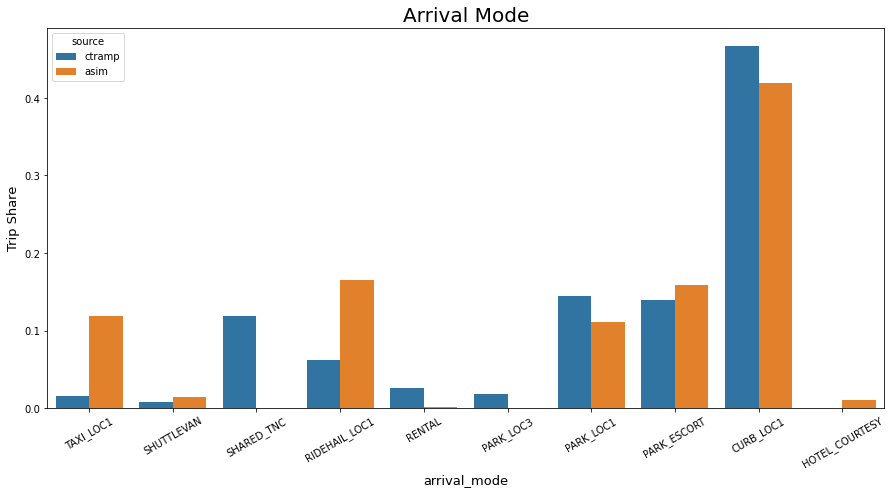

In [63]:
fig,ax1 = plt.subplots(figsize=(15,7))

fig = sns.barplot(data=ctramp.append(asim).groupby(['arrival_mode','source']).sum().reset_index().sort_values(['source','arrival_mode'],ascending = False), x='arrival_mode',y = 'weight', hue='source', ci = None)
ax1.set_ylabel('Trip Share', fontsize=13)
ax1.set_xticklabels(labels=ax1.get_xticklabels(),fontsize=10, rotation = 30)
ax1.set_xlabel(ax1.get_xlabel(), fontsize=13)
ax1.set_title("Arrival Mode", fontsize = 20)


In [64]:
mode_shares = ctramp.append(asim).groupby(['arrival_mode','source'])[['weight']].sum().reset_index().sort_values(['source','arrival_mode'],ascending = False)
mode_shares = mode_shares.pivot(index = ['arrival_mode'], columns = 'source', values = 'weight')
mode_shares['diff'] = mode_shares['asim'] - mode_shares['ctramp']
mode_shares['ctramp'] = mode_shares['ctramp'].map(lambda n: "{:.2f}%".format(n*100))
mode_shares['asim'] = mode_shares['asim'].map(lambda n: "{:.2f}%".format(n*100))
mode_shares['diff'] = mode_shares['diff'].map(lambda n: "{:.2f}%".format(n*100))
mode_shares[['ctramp','asim','diff']].sort_values('arrival_mode')

source,ctramp,asim,diff
arrival_mode,,,
CURB_LOC1,46.74%,41.94%,-4.80%
HOTEL_COURTESY,nan%,1.10%,nan%
PARK_ESCORT,13.88%,15.90%,2.03%
PARK_LOC1,14.45%,11.06%,-3.39%
PARK_LOC3,1.85%,nan%,nan%
RENTAL,2.64%,0.13%,-2.51%
RIDEHAIL_LOC1,6.21%,16.56%,10.35%
SHARED_TNC,11.89%,nan%,nan%
SHUTTLEVAN,0.79%,1.41%,0.62%


In [65]:
# fig,ax1 = plt.subplots(figsize=(15,7))
# data_df = ctramp[ctramp.direction == 'inbound'].append(asim[asim.direction == 'inbound']).groupby(['arrival_mode','source']).sum().reset_index().sort_values(['source','arrival_mode'],ascending = False)
# fig = sns.barplot(data=data_df, x='arrival_mode',y = 'weight', hue='source', ci = None)
# ax1.set_ylabel('Trip Share', fontsize=13)
# ax1.set_xticklabels(labels=ax1.get_xticklabels(),fontsize=10, rotation = 30)
# ax1.set_xlabel(ax1.get_xlabel(), fontsize=13)
# ax1.set_title("Inbound Arrival Mode", fontsize = 20)


In [66]:
# fig,ax1 = plt.subplots(figsize=(15,7))
# data_df = ctramp[ctramp.direction == 'outbound'].append(asim[asim.direction == 'outbound']).groupby(['arrival_mode','source']).sum().reset_index().sort_values(['source','arrival_mode'],ascending = False)
# fig = sns.barplot(data=data_df, x='arrival_mode',y = 'weight', hue='source', ci = None)
# ax1.set_ylabel('Trip Share', fontsize=13)
# ax1.set_xticklabels(labels=ax1.get_xticklabels(),fontsize=10, rotation = 30)
# ax1.set_xlabel(ax1.get_xlabel(), fontsize=13)
# ax1.set_title("Outbound Arrival Mode", fontsize = 20)


Text(0.5, 1.0, 'Resident Business')

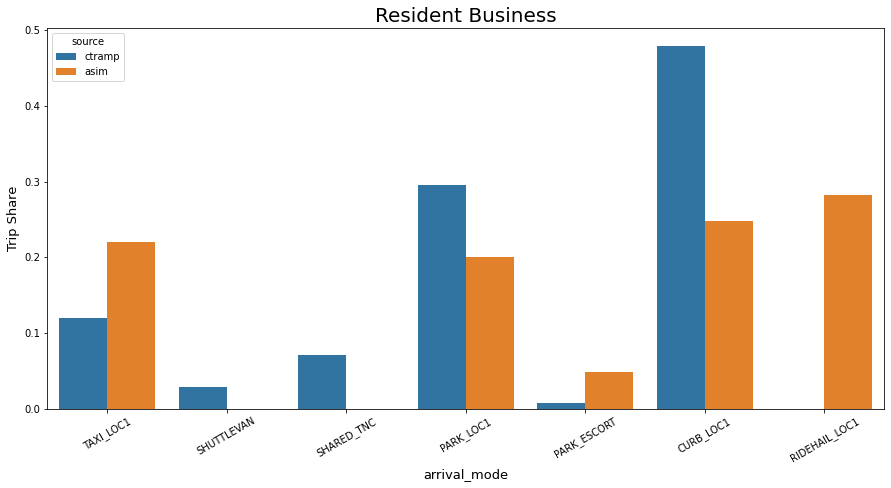

In [67]:
fig,ax1 = plt.subplots(figsize=(15,7))
ctramp['weight'] = 1/len(ctramp[ctramp.tour_type == 'res_bus'])
asim['weight'] = 1/len(asim[asim.tour_type == 'res_bus'])
data_df = ctramp[ctramp.tour_type == 'res_bus'].append(asim[asim.tour_type == 'res_bus']).groupby(['arrival_mode','source']).sum().reset_index().sort_values(['source','arrival_mode'],ascending = False)
fig = sns.barplot(data=data_df, x='arrival_mode',y = 'weight', hue='source', ci = None)
ax1.set_ylabel('Trip Share', fontsize=13)
ax1.set_xticklabels(labels=ax1.get_xticklabels(),fontsize=10, rotation = 30)
ax1.set_xlabel(ax1.get_xlabel(), fontsize=13)
ax1.set_title("Resident Business", fontsize = 20)


Text(0.5, 1.0, 'Resident Personal')

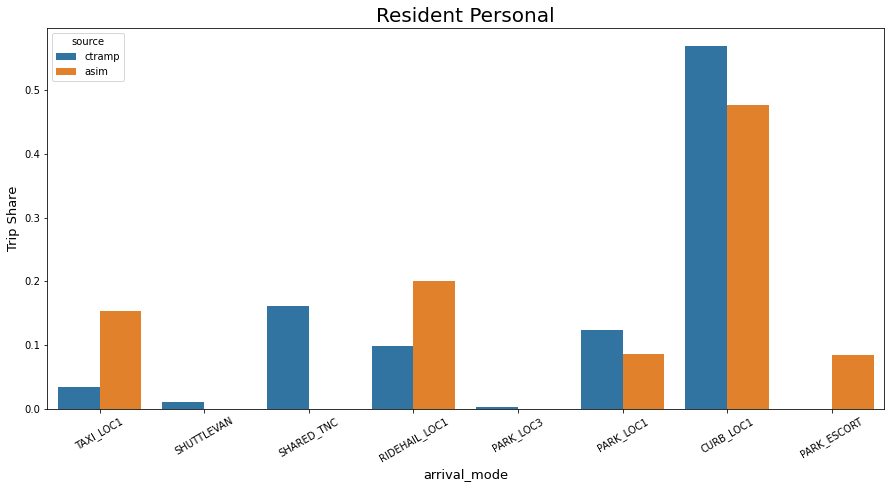

In [68]:
fig,ax1 = plt.subplots(figsize=(15,7))
ctramp['weight'] = 1/len(ctramp[ctramp.tour_type == 'res_per'])
asim['weight'] = 1/len(asim[asim.tour_type == 'res_per'])
data_df = ctramp[ctramp.tour_type == 'res_per'].append(asim[asim.tour_type == 'res_per']).groupby(['arrival_mode','source']).sum().reset_index().sort_values(['source','arrival_mode'],ascending = False)
fig = sns.barplot(data=data_df, x='arrival_mode',y = 'weight', hue='source', ci = None)
ax1.set_ylabel('Trip Share', fontsize=13)
ax1.set_xticklabels(labels=ax1.get_xticklabels(),fontsize=10, rotation = 30)
ax1.set_xlabel(ax1.get_xlabel(), fontsize=13)
ax1.set_title("Resident Personal", fontsize = 20)


Text(0.5, 1.0, 'Visitor Business')

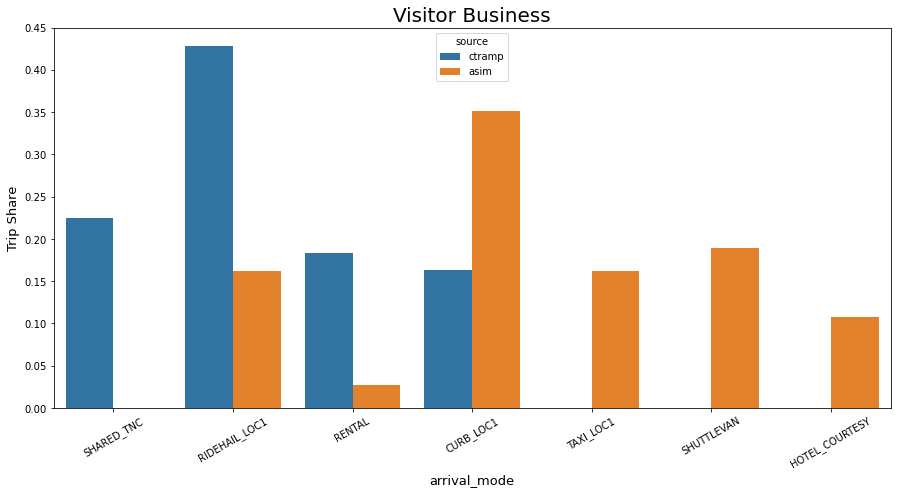

In [69]:
fig,ax1 = plt.subplots(figsize=(15,7))
ctramp['weight'] = 1/len(ctramp[ctramp.tour_type == 'vis_bus'])
asim['weight'] = 1/len(asim[asim.tour_type == 'vis_bus'])
data_df = ctramp[ctramp.tour_type == 'vis_bus'].append(asim[asim.tour_type == 'vis_bus']).groupby(['arrival_mode','source']).sum().reset_index().sort_values(['source','arrival_mode'],ascending = False)
fig = sns.barplot(data=data_df, x='arrival_mode',y = 'weight', hue='source', ci = None)
ax1.set_ylabel('Trip Share', fontsize=13)
ax1.set_xticklabels(labels=ax1.get_xticklabels(),fontsize=10, rotation = 30)
ax1.set_xlabel(ax1.get_xlabel(), fontsize=13)
ax1.set_title("Visitor Business", fontsize = 20)


Text(0.5, 1.0, 'Visitor Personal')

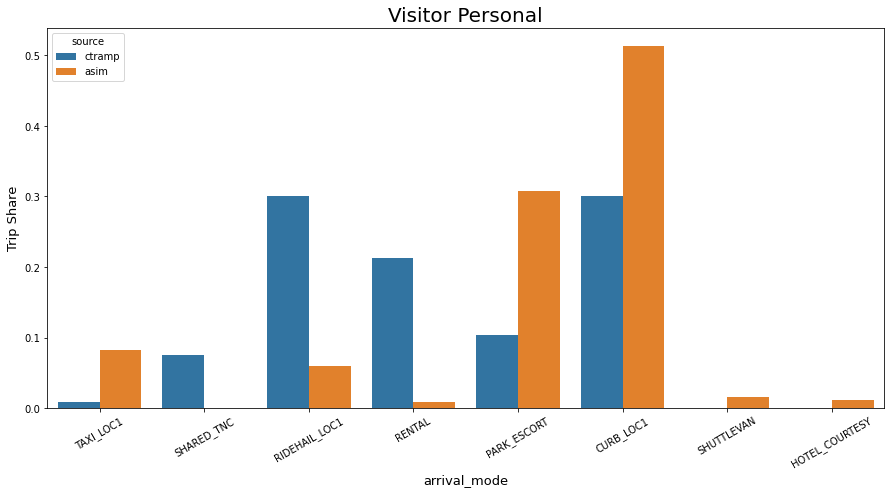

In [70]:
fig,ax1 = plt.subplots(figsize=(15,7))
ctramp['weight'] = 1/len(ctramp[ctramp.tour_type == 'vis_per'])
asim['weight'] = 1/len(asim[asim.tour_type == 'vis_per'])
data_df = ctramp[ctramp.tour_type == 'vis_per'].append(asim[asim.tour_type == 'vis_per']).groupby(['arrival_mode','source']).sum().reset_index().sort_values(['source','arrival_mode'],ascending = False)
fig = sns.barplot(data=data_df, x='arrival_mode',y = 'weight', hue='source', ci = None)
ax1.set_ylabel('Trip Share', fontsize=13)
ax1.set_xticklabels(labels=ax1.get_xticklabels(),fontsize=10, rotation = 30)
ax1.set_xlabel(ax1.get_xlabel(), fontsize=13)
ax1.set_title("Visitor Personal", fontsize = 20)


Text(0.5, 1.0, 'External')

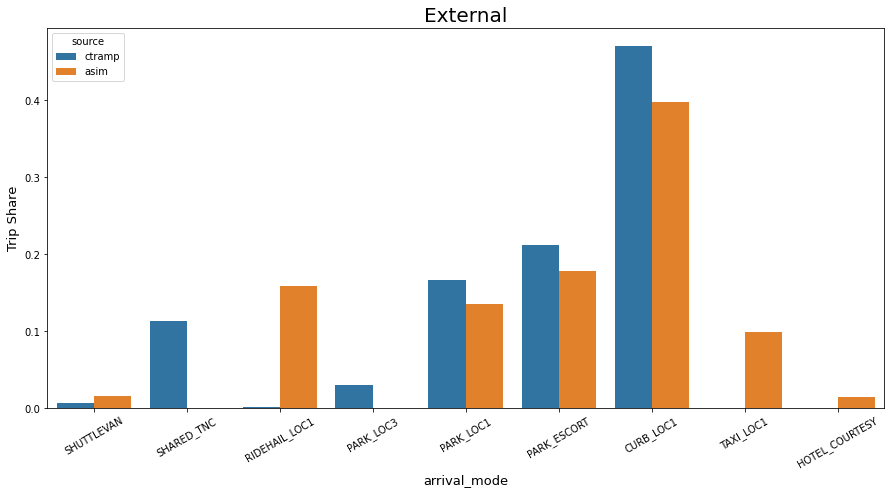

In [71]:
fig,ax1 = plt.subplots(figsize=(15,7))
ctramp['weight'] = 1/len(ctramp[ctramp.tour_type == 'external'])
asim['weight'] = 1/len(asim[asim.tour_type == 'external'])
data_df = ctramp[ctramp.tour_type == 'external'].append(asim[asim.tour_type == 'external']).groupby(['arrival_mode','source']).sum().reset_index().sort_values(['source','arrival_mode'],ascending = False)
fig = sns.barplot(data=data_df, x='arrival_mode',y = 'weight', hue='source', ci = None)
ax1.set_ylabel('Trip Share', fontsize=13)
ax1.set_xticklabels(labels=ax1.get_xticklabels(),fontsize=10, rotation = 30)
ax1.set_xlabel(ax1.get_xlabel(), fontsize=13)
ax1.set_title("External", fontsize = 20)


In [72]:
ctramp.arrival_mode.unique()

array(['CURB_LOC1', 'PARK_ESCORT', 'PARK_LOC1', 'RENTAL', 'RIDEHAIL_LOC1',
       'SHARED_TNC', 'TAXI_LOC1', 'PARK_LOC3', 'SHUTTLEVAN'], dtype=object)